In [1]:
!nvidia-smi

Thu Feb 15 14:50:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## clone YOLOv5 repository

In [2]:

!git clone https://github.com/ultralytics/yolov5.git  

Cloning into 'yolov5'...
remote: Enumerating objects: 16413, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16413 (delta 0), reused 3 (delta 0), pack-reused 16408
Receiving objects: 100% (16413/16413), 14.96 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (11263/11263), done.


## install necessary dependencies


In [5]:
!pip install -qr requirements.txt  
import torch
import gdown
from IPython.display import Image, clear_output  # to display images
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


## Dowdloading data from gdrive

In [9]:

url = "https://drive.google.com/file/d/1CWSwE0hQOl05c1B9f2SM4j5cjohxZ6Fm/view?usp=sharing"
file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id, "sign_data.zip")

1CWSwE0hQOl05c1B9f2SM4j5cjohxZ6Fm


Downloading...
From: https://drive.google.com/uc?/export=download&id=1CWSwE0hQOl05c1B9f2SM4j5cjohxZ6Fm
To: /content/sign_data.zip
100%|██████████| 10.3M/10.3M [00:00<00:00, 34.9MB/s]


'sign_data.zip'

## Unzipping downloaded data

In [10]:
!unzip sign_data.zip

Archive:  sign_data.zip
  inflating: data.yaml               
   creating: test/images/
  inflating: test/images/Hello.82af5cd8-a6d1-11ec-a2fc-84a93ea18ae6.jpg  
  inflating: test/images/Hello.8b2540a6-a6d1-11ec-a828-84a93ea18ae6 - Copy.jpg  
  inflating: test/images/Hello.8b2540a6-a6d1-11ec-a828-84a93ea18ae6.jpg  
  inflating: test/images/Hello.8c5b98c8-a6d1-11ec-a905-84a93ea18ae6.jpg  
  inflating: test/images/Hello.8d922278-a6d1-11ec-9c17-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.01279dee-a6d2-11ec-a775-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.0391a1b8-a6d2-11ec-9246-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.04c7764c-a6d2-11ec-998a-84a93ea18ae6 - Copy.jpg  
  inflating: test/images/IloveYou.04c7764c-a6d2-11ec-998a-84a93ea18ae6.jpg  
  inflating: test/images/IloveYou.05fc3c80-a6d2-11ec-ba0a-84a93ea18ae6.jpg  
  inflating: test/images/No.b81769f8-a6d1-11ec-8d33-84a93ea18ae6.jpg  
  inflating: test/images/No.b94ba4ee-a6d1-11ec-b2ba-84a93ea18ae6.jpg  
 

## Loading the data.yaml file to view the number of classes

In [11]:

%cat data.yaml

train: ../train/images
val: ../test/images

nc: 6
names: ['Hello', 'IloveYou', 'No', 'Please', 'Thanks', 'Yes']


# Define Model Configuration and Architecture


In [12]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

## Changing the number of classes in yaml file

In [13]:
num_classes

'6'

In [14]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

## customizing iPython writefile so we can write variables

In [15]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [16]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Getting started with training the yolov5 model on my custom data

In [17]:

%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
2024-02-15 14:51:57.986713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 14:51:57.986773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 14:51:57.988114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, devi

## Plotting the loss curves for my trained model

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



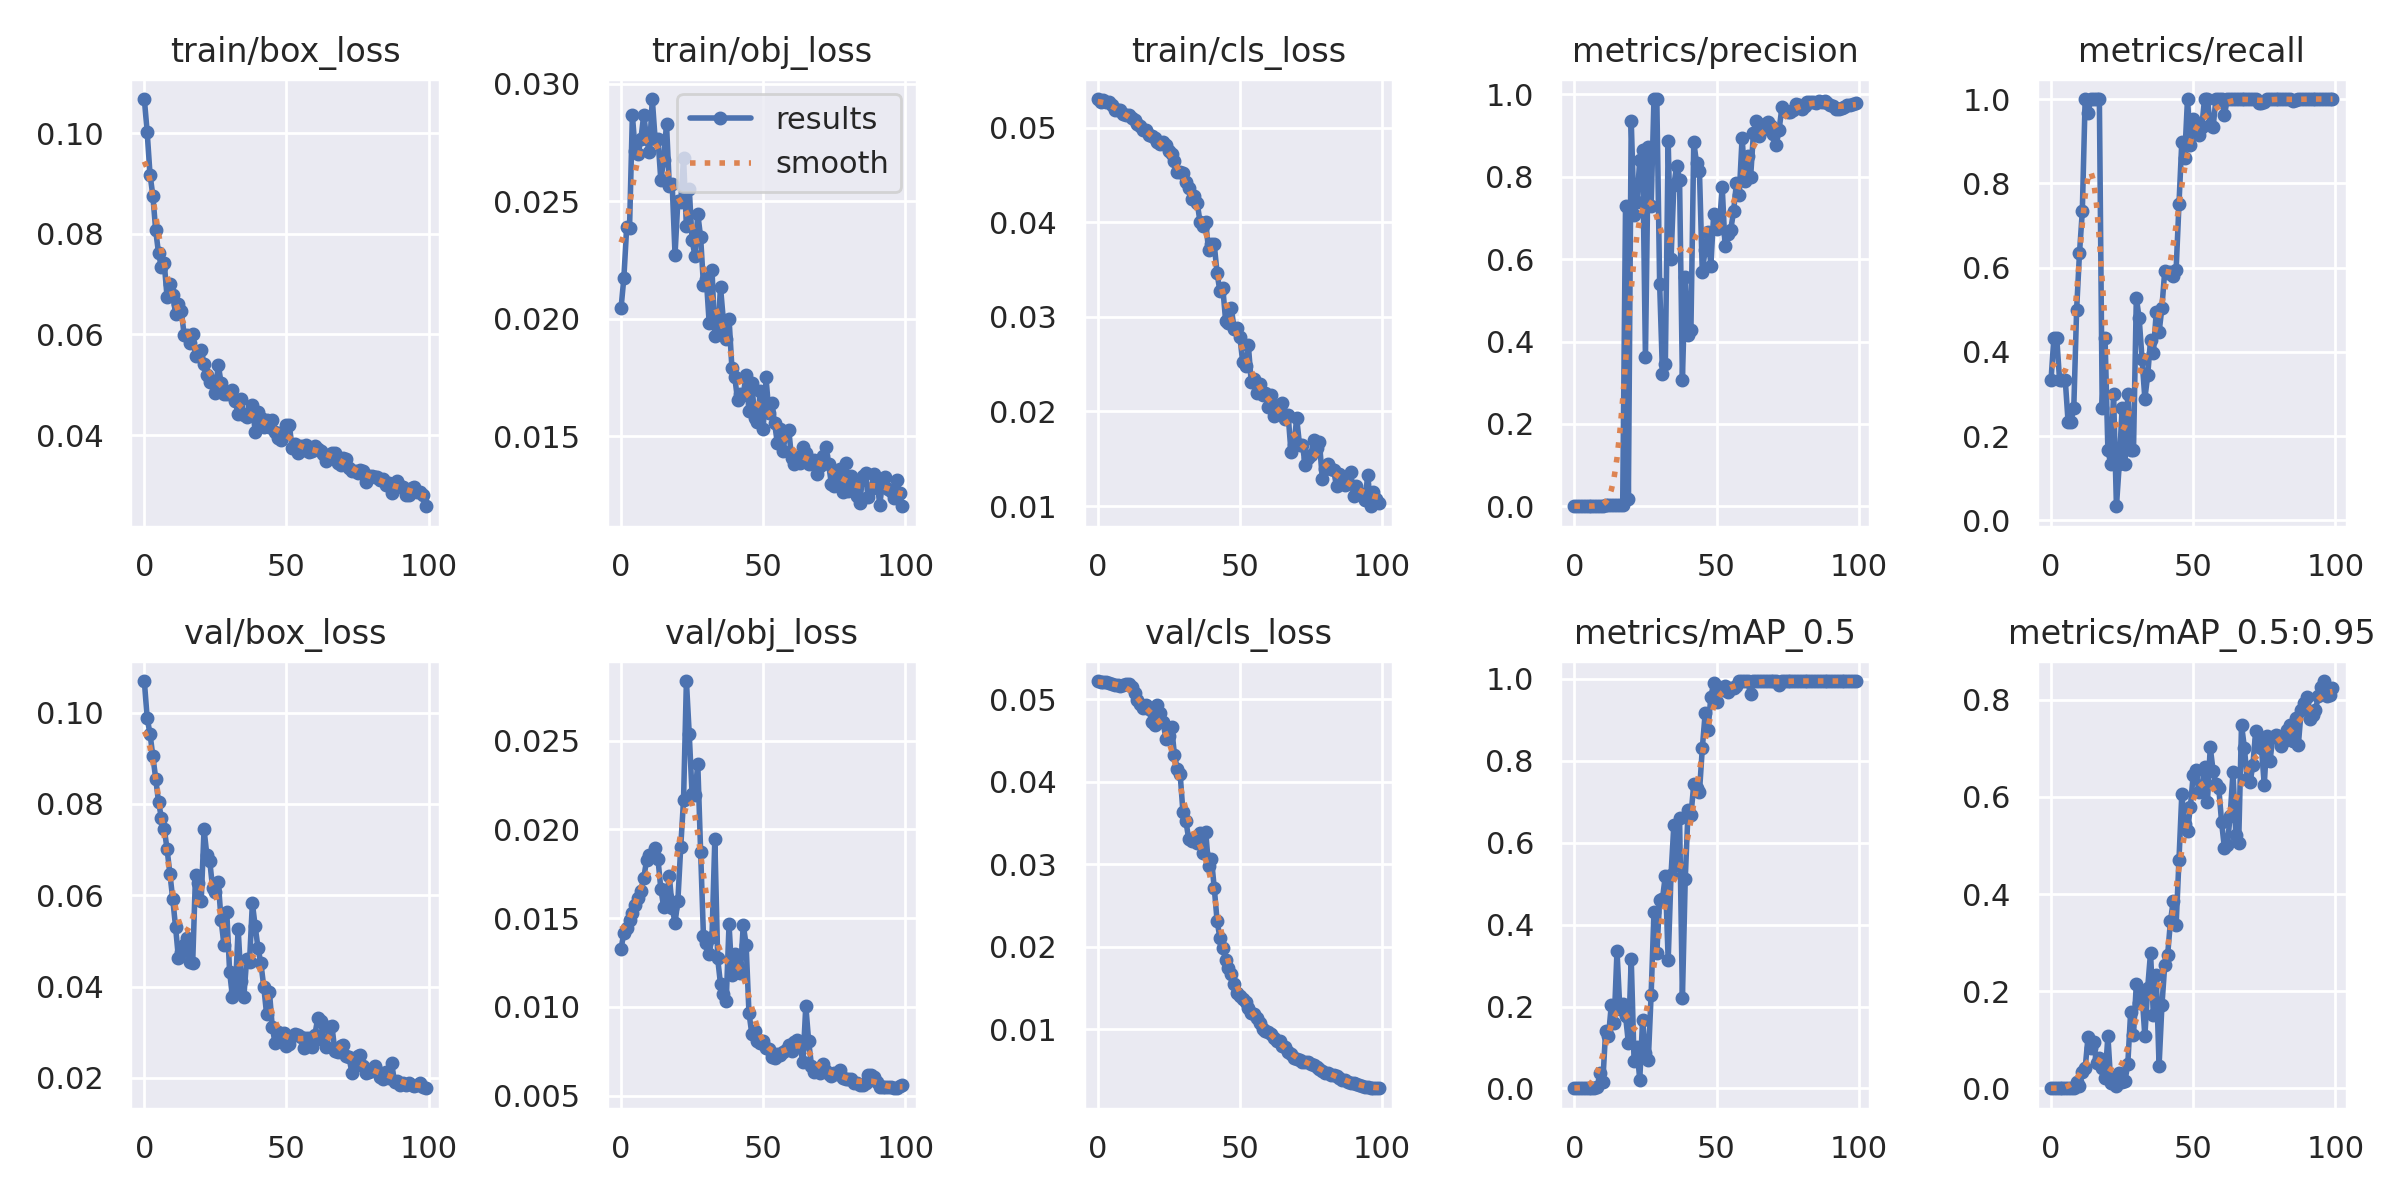

In [ ]:
from utils.plots import plot_results  
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000) 

## Visualizing the ground truth on training images

GROUND TRUTH TRAINING DATA:


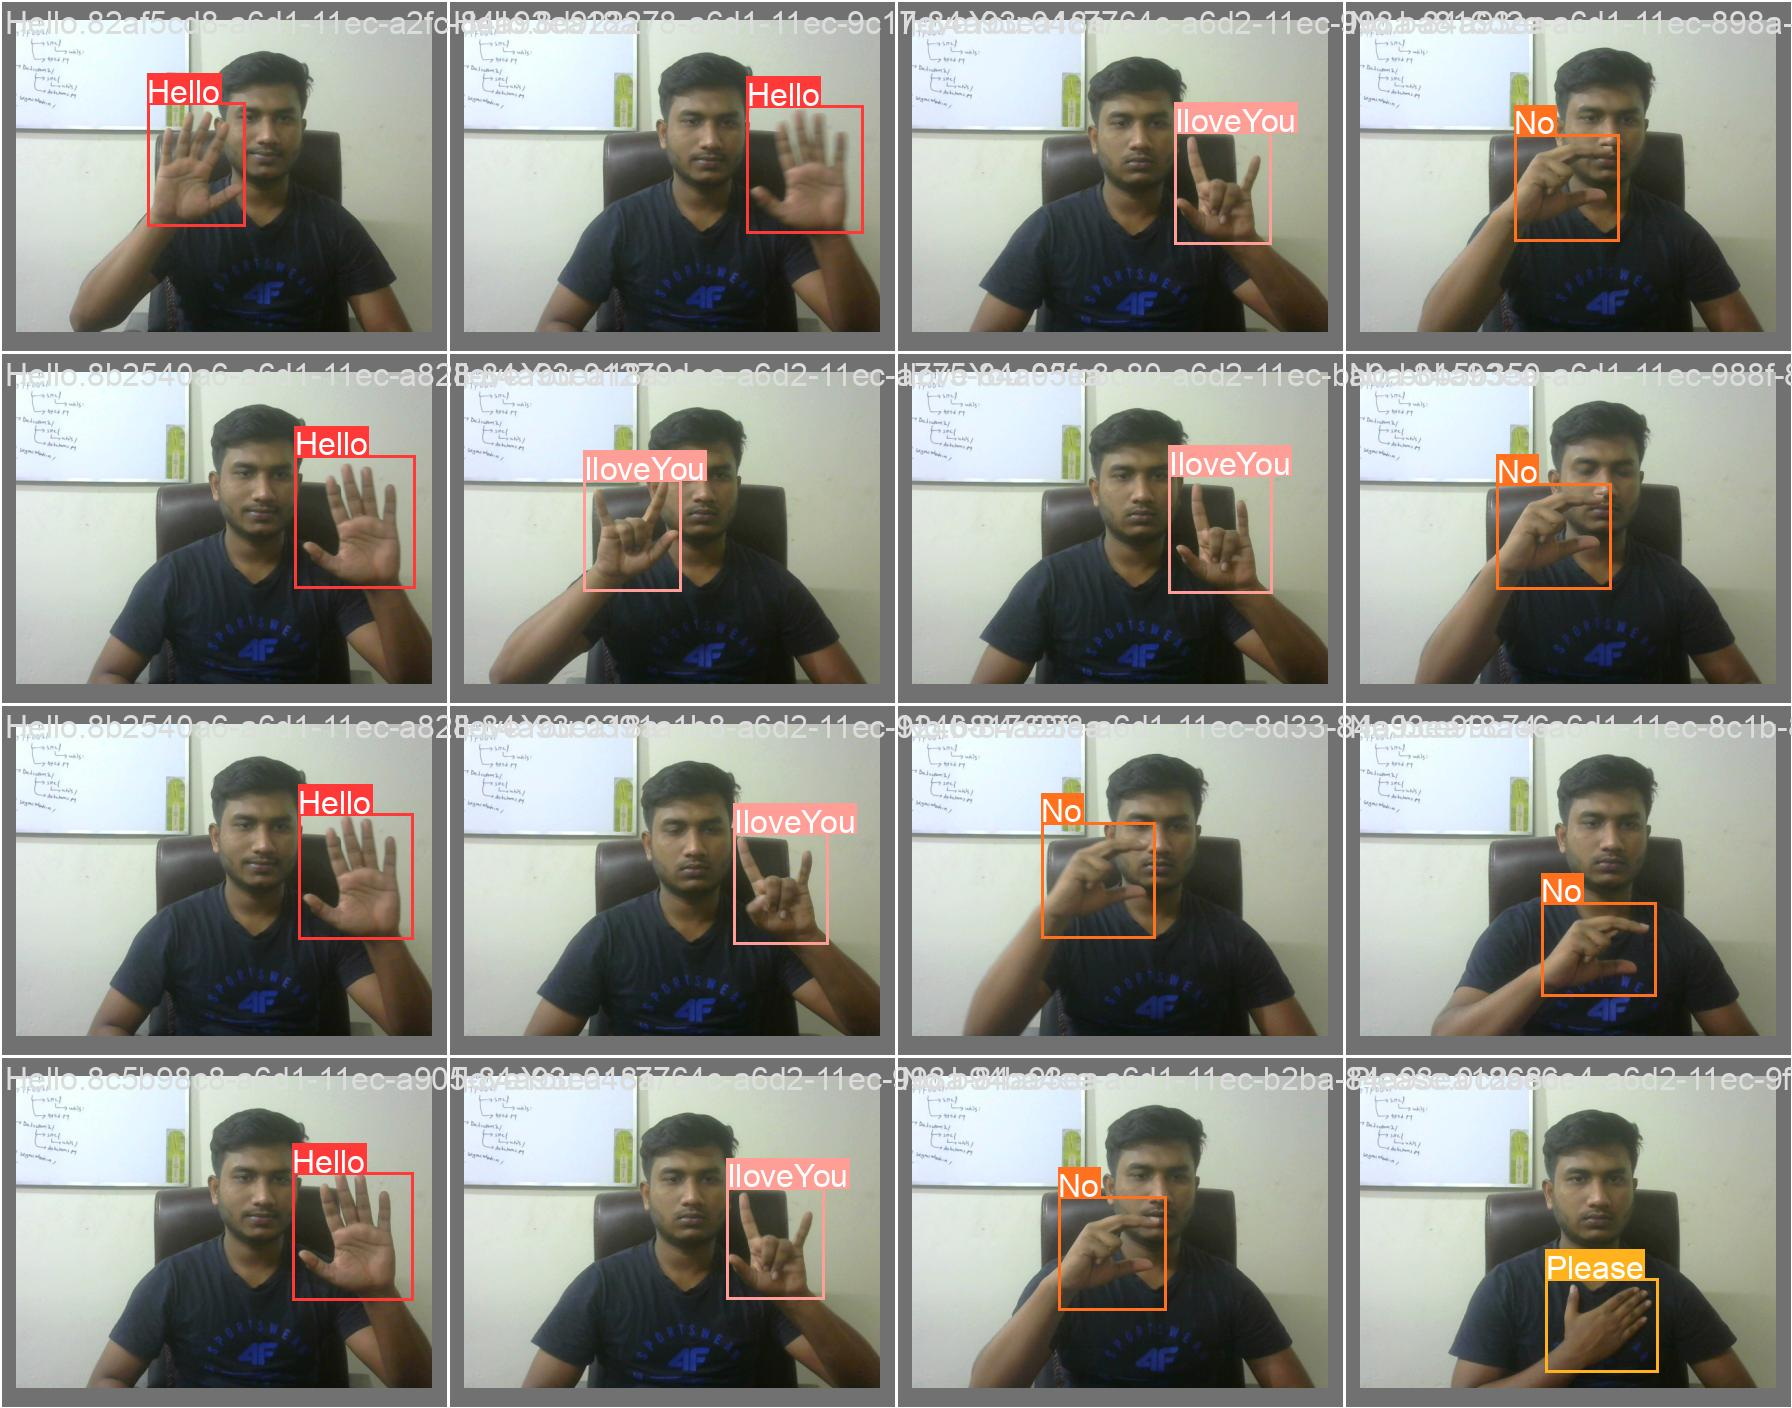

In [19]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

## Visualising ground truth on augmented training images

GROUND TRUTH AUGMENTED TRAINING DATA:


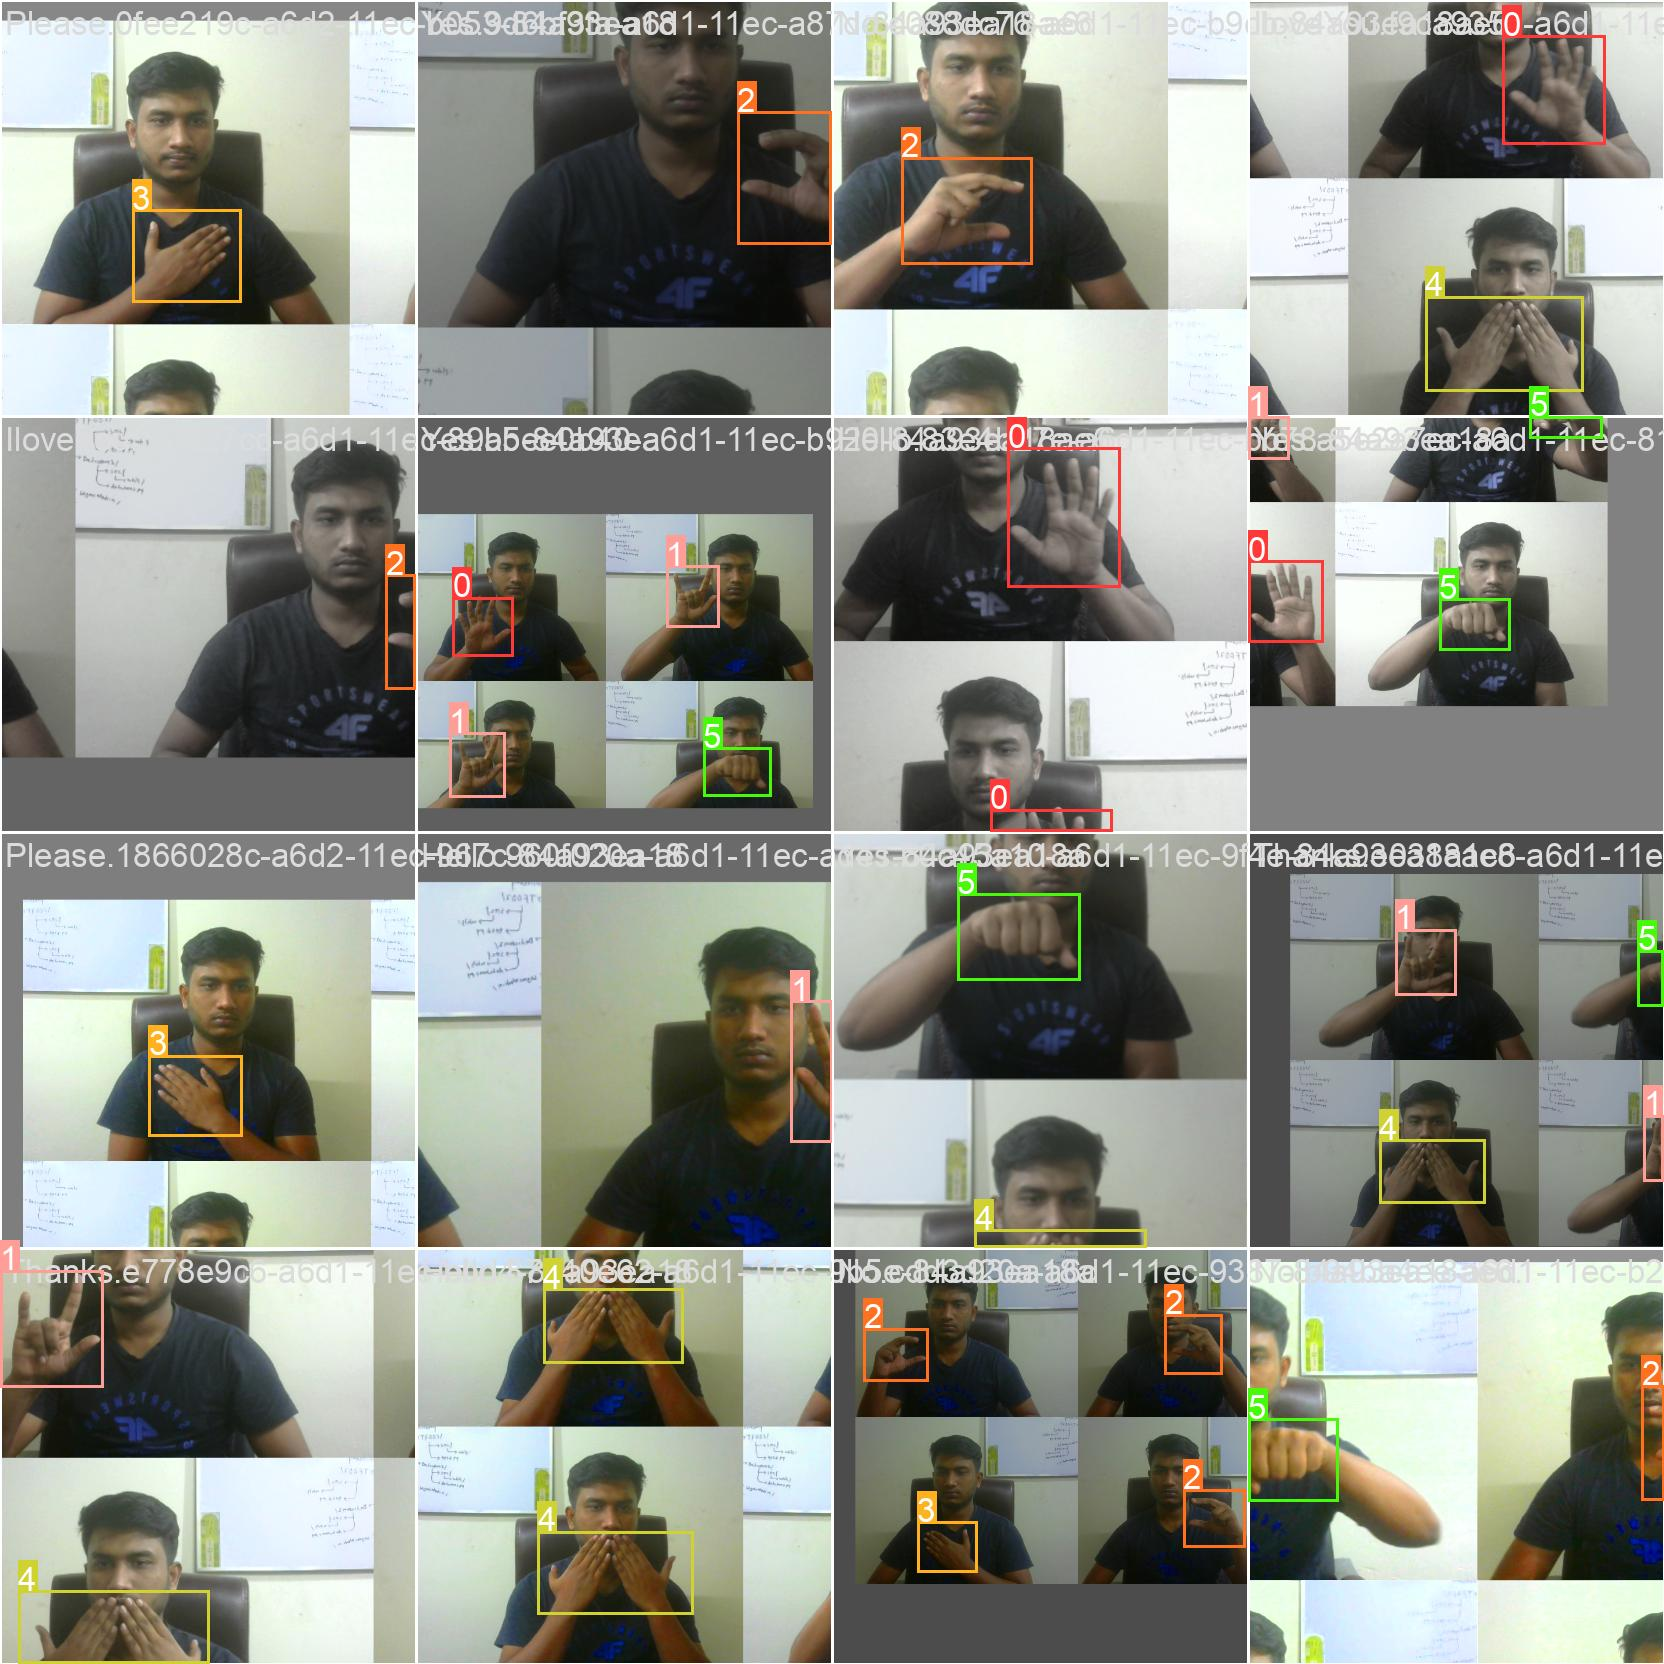

In [ ]:

print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)